In [39]:
import sys
sys.path.append('../scripts/')

from time import time
import glob
import warnings
import param

import numpy as np
import pandas as pd
import xarray as xr
from scipy.special import gammaln
from scipy.optimize import curve_fit, minimize
from scipy.stats import pearsonr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind',font_scale=1.5)
mpl.rc('figure', dpi=100, figsize=[6, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

%matplotlib inline

In [2]:
dsv = xr.open_dataset('../data/chi/variable_dof.nc')
dsf = xr.open_dataset('../data/chi/fixed_dof.nc')

In [3]:
def plot_hist(ds):
    ind, bins = np.histogram(ds.eps1_kra, bins=30, range=(1e-12,1e-7));
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    ds.eps1_kra.plot.hist(xscale='log', bins=logbins);

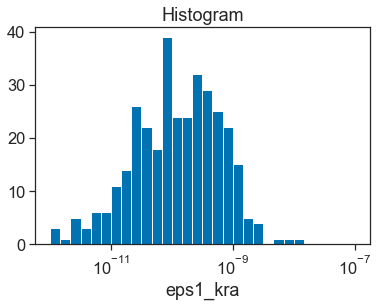

In [4]:
plot_hist(dsv)

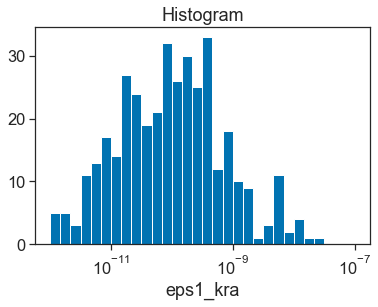

In [5]:
plot_hist(dsf)

In [6]:
ds = xr.Dataset()
ds['variable'] = dsv.eps1_kra
ds['fixed'] = dsf.eps1_kra
ds['rc'] = dsf.eps_rc

(1e-13, 5e-08)

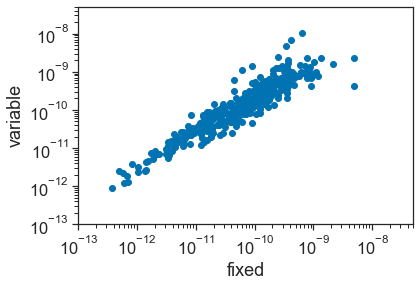

In [8]:


ds.plot.scatter(x='fixed', y='variable',marker='o')
ds.where( (ds.fixed < 3.05e-9) & (ds.fixed > 3.04e-9)).plot.scatter(x='fixed', y='variable',marker='o', color='red')
ds.where( (ds.variable < 3.05e-9) & (ds.variable > 3.04e-9)).plot.scatter(x='fixed', y='variable',marker='o', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,5e-8)
plt.ylim(1e-13,5e-8)

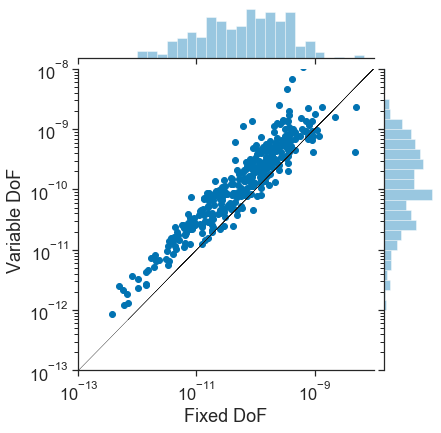

In [40]:
ind, bins = np.histogram(ds.fixed, bins=30, range=(1e-12,1e-7));
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

g = sns.jointplot(x='fixed',y='variable',data=ds, kind='scatter',dropna=True,
             xlim=(1e-13,1e-8),ylim=(1e-13,1e-8), marginal_kws={'bins':logbins} )
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set_xlabel('Fixed DoF')
g.ax_joint.set_ylabel('Variable DoF')

g.ax_joint.plot(ds.fixed, ds.fixed, color='k', lw=0.2)

plt.savefig('../figures/fixed_vs_variable_dof.pdf')

In [144]:
mask = (dsf.eps1_bat < 3.05e-9) & (dsf.eps1_bat > 3.04e-9)

In [145]:
ds = dsf.where(mask)

ds.dropna(dim='time', how='all')
ds['itime'] = ('time',np.arange(0,len(ds.time)))

hover_cols = ['eps1_bat','eps1_kra','eps2_bat','eps2_kra', 'lhr1_bat']
arguments = {'hover_cols':hover_cols,'legend':'left','groupby':'itime','loglog':True}

obs = ds.hvplot(x='k_rpm',y='corrdTdzsp1_rpm',label='Observed',**arguments)
noi = ds.hvplot(x='k_rpm',y='noise_rpm',label='Noise',line_dash='dotted',**arguments)
bat = ds.hvplot(x='k_rpm',y='bat1',label='Batchelor',**arguments)
krai = ds.hvplot(x='k_rpm',y='kra1',label='Kraichnan',**arguments)
power = ds.hvplot(x='k_rpm',y='power1',label='Power law',line_dash='dashed',**arguments)
rc = ds.hvplot(x='k_rpm',y='bat1_rc',label='Ren-Chieh',**arguments)

In [137]:
ds

<xarray.Dataset>
Dimensions:          (f_cps: 20, time: 787)
Coordinates:
  * f_cps            (f_cps) float64 0.125 0.175 0.225 0.3 ... 28.33 39.08 53.9
  * time             (time) datetime64[ns] 2017-09-25T06:40:35 ... 2017-10-06T01:36:50
    z                (time) float64 -481.3 -480.3 -479.1 -478.0 ... nan nan nan
    k_rpm            (time, f_cps) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    dof              (time) float64 nan nan nan 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
    p                (time) float64 nan nan nan 478.0 ... 0.02857 nan nan nan
    N2               (time) float64 nan nan nan 1.542e-05 ... nan nan nan
    N                (time) float64 nan nan nan 0.003927 ... 0.1035 nan nan nan
    T                (time) float64 nan nan nan 5.15 5.158 ... 21.81 nan nan nan
    dTdz             (time) float64 nan nan nan 0.008537 ... nan nan nan
    w                (time) float64 nan nan nan 0.1002 ... 0.08994 nan nan nan
    k_cpm            (time, f_cps) floa

In [136]:
(obs*bat*krai*rc*power*noi).options(height=600,ylim=(1e-9, 1e-2),xlim=(1e1,2e3),
                      title=f'Temperature Gradient Spectra',
                      xlabel=r'k_z',ylabel='dPhidz',
                      fontsize={'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12, 'legend':12})

:DynamicMap   [itime]
   :Overlay
      .Curve.Observed               :Curve   [k_rpm]   (corrdTdzsp1_rpm,eps1_bat,eps1_kra,eps2_bat,eps2_kra,lhr1_bat)
      .Curve.Batchelor              :Curve   [k_rpm]   (bat1,eps1_bat,eps1_kra,eps2_bat,eps2_kra,lhr1_bat)
      .Curve.Kraichnan              :Curve   [k_rpm]   (kra1,eps1_bat,eps1_kra,eps2_bat,eps2_kra,lhr1_bat)
      .Curve.Ren_hyphen_minus_Chieh :Curve   [k_rpm]   (bat1_rc,eps1_bat,eps1_kra,eps2_bat,eps2_kra,lhr1_bat)
      .Curve.Power_law              :Curve   [k_rpm]   (power1,eps1_bat,eps1_kra,eps2_bat,eps2_kra,lhr1_bat)
      .Curve.Noise                  :Curve   [k_rpm]   (noise_rpm,eps1_bat,eps1_kra,eps2_bat,eps2_kra,lhr1_bat)

(1e-13, 5e-07)

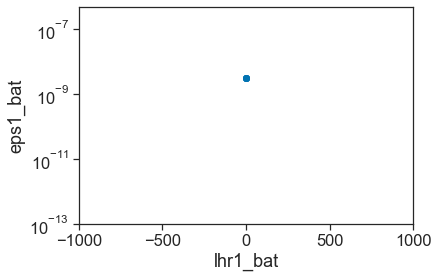

In [133]:
ds.plot.scatter(x='lhr1_bat',y='eps1_bat')
# plt.yscale('log')
plt.yscale('log')
plt.xlim(-1000,1000)
plt.ylim(1e-13,5e-7)